In [1]:
import keras
import numpy as np
import pretty_midi
import librosa
import glob
import os
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from train_util import NoteIsoSequence
from model import get_autoencoder, get_vae, get_gan
from train_util import program_map, one_hot_map
from keras import backend as K
import time
import sklearn
from hparams import *
import random

# synthesize without label and then add back for train?
# loud not at the end to force normalization?

Using TensorFlow backend.


In [2]:
midi_root_dir = "/home/faraaz/workspace/music-transcription/data/clean_midi/"
midi_files = glob.iglob(os.path.join(midi_root_dir, '**', '*.mid'))
midi_file = next(midi_files)
print(midi_file)
test_midi_file = wav_files[109][:-4] + ".mid"
print(test_midi_file)
pm = pretty_midi.PrettyMIDI(test_midi_file)
n_instruments = len(pm.instruments)
print(n_instruments)
for instr in pm.instruments:
    print("{}: {}".format(len(instr.notes), instr))
test_wav_files = [test_midi_file[:-4]+".wav"]

/home/faraaz/workspace/music-transcription/data/clean_midi/Redbone/Come and Get Your Love.mid
/home/faraaz/workspace/music-transcription/data/clean_midi/The Moody Blues/The Other Side of Life.mid
3
204: Instrument(program=17, is_drum=False, name="Organ")
187: Instrument(program=30, is_drum=False, name="Guitar3")
3: Instrument(program=107, is_drum=False, name="FX2")


In [3]:
print("loading model")
model_type = 'ae'

if model_type == 'ae':
    encoder = keras.models.load_model("ae/encoder-test2.h")
    decoder = keras.models.load_model("ae/decoder-test2.h")
    _, _, autoencoder = get_autoencoder(encoder, decoder)
elif model_type == 'ae+':
    encoder = keras.models.load_model("ae+/encoder-5.h")
    classifier = keras.models.load_model("ae+/classifier-5.h")
elif model_type == 'vae':
    encoder = keras.models.load_model("vae/encoder-test2.h")
    decoder = keras.models.load_model("vae/decoder-test2.h")
    encoder, decoder, autoencoder, _ = get_vae(encoder, decoder)
#     autoencoder = keras.models.load_model('vae/vae-0.h', custom_objects={'my_vae_loss': my_vae_loss})
elif model_type == 'gan':
    autoencoder = keras.models.load_model('gan/ae-0.h')
else:
    assert False

loading model


/home/faraaz/anaconda3/envs/urop/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
test_batch_size = 1
test_generator = NoteIsoSequence(test_wav_files, sample_duration=sample_duration, 
                                 sample_rate=sample_rate, n_fft=n_fft, instr_indices=[],
                                 note_indices=[], song_indices=[], batch_size=test_batch_size)
test_song_indices = test_generator.song_indices
test_instr_indices = test_generator.instr_indices
test_note_indices = test_generator.note_indices
test_instr_labels = np.array(test_generator.instr_labels)
test_pitch_labels = np.array(test_generator.pitch_labels)

In [5]:
print("predicting embeddings...")
start = time.time()
if model_type == 'vae':
    means, variances, embeddings = encoder.predict_generator(test_generator)
else:
    embeddings = encoder.predict_generator(test_generator)
print("{}s".format(time.time()-start))
print(len(embeddings))
print(embeddings.shape)
start = time.time()
# instr_preds = classifier.predict_generator(test_generator)
# print("{}s".format(time.time()-start))
# print(len(instr_preds))
# print(instr_preds.shape)

predicting embeddings...
20.759594440460205s
394
(394, 2)


In [6]:
n_clusters = n_instruments
kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters)
embed_clusters = kmeans.fit_predict(embeddings)
score = sklearn.metrics.adjusted_rand_score(test_instr_indices, embed_clusters)  
print(score)

0.3591776069017585


In [7]:
for i in range(n_clusters):
    print("{}. {}".format(i, np.sum(np.count_nonzero(embed_clusters == i))))

0. 118
1. 112
2. 164


In [8]:
for i in range(128):
    count = np.sum(np.count_nonzero(test_instr_labels == i))
    if count != 0:
        print("{}. {}".format(i, count))

17. 204
30. 187
107. 3


In [9]:
# confusion matrix on instrument label
confusion_matrix = np.zeros((n_clusters, 128))
for i in range(len(test_instr_labels)):
    instr_label = test_instr_labels[i]
    embed_cluster = embed_clusters[i]
    confusion_matrix[embed_cluster][instr_label] += 1

for i in range(len(confusion_matrix)):
    print(confusion_matrix[i])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 61.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 57.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 112.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   

In [10]:
# confusion matrix on pitch label
confusion_matrix = np.zeros((128, n_clusters))
for i in range(len(test_instr_labels)):
    pitch_label = test_pitch_labels[i]
    embed_cluster = embed_clusters[i]
    confusion_matrix[pitch_label][embed_cluster] += 1

for i in range(len(confusion_matrix)):
    print(confusion_matrix[i])

[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[56.  0.  0.]
[ 0. 24.  0.]
[0. 0. 0.]
[ 0. 20.  0.]
[0. 0. 0.]
[ 0. 44.  0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[3. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[5. 0. 0.]
[7. 0. 0.]
[0. 0. 0.]
[9. 0. 0.]
[0. 0. 0.]
[5. 0. 0.]
[0. 0. 3.]
[21.  0.  0.]
[ 0.  3. 24.]
[0. 0. 0.]
[ 0.  3. 29.]
[0. 0. 0.]
[ 0.  5. 31.]
[ 0.  0. 13.]
[0. 0. 0.]
[ 0.  8. 11.]
[0. 0. 0.]
[ 0.  0. 39.]
[0. 0. 0.]
[0. 0. 3.]
[12.  5.  0.]
[0. 0. 0.]
[0. 0. 3.]
[0. 0. 0.]
[0. 0. 4.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 4.]
[0. 0. 

388
(64, 64)
sample_instr 17
sample_pitch 71
sample_cluster 2
sample_embed [0.10608246 0.15385711]
(64, 64)


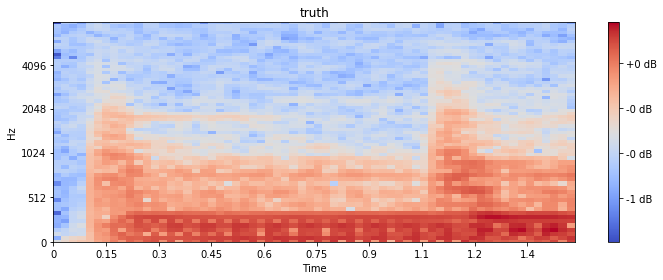

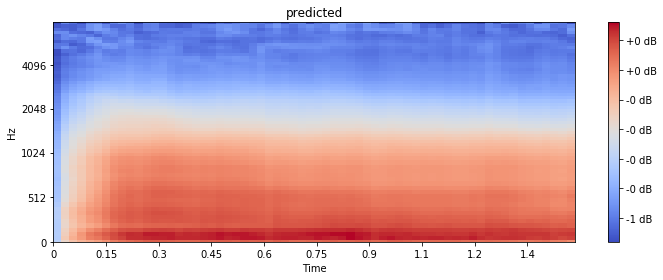

In [11]:
sample_index = np.random.randint(len(test_instr_labels))
iso_mag = test_generator[sample_index][0][0][:,:,0]
print(sample_index)
print(iso_mag.shape)

sample_instr = test_instr_labels[sample_index]
sample_pitch = test_pitch_labels[sample_index]
sample_embed = embeddings[sample_index]
sample_cluster = embed_clusters[sample_index]
instr_index = test_generator.instr_indices[sample_index]
note_index = test_generator.note_indices[sample_index]
song_index = test_generator.song_indices[sample_index]

print("sample_instr {}".format(sample_instr))
print("sample_pitch {}".format(sample_pitch))
print("sample_cluster {}".format(sample_cluster))
print("sample_embed {}".format(sample_embed))

plt.figure(figsize=(10, 4))
librosa.display.specshow(iso_mag, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('truth')
plt.tight_layout()

small_test_generator = NoteIsoSequence(
    train_wav_files, sample_duration=sample_duration, sample_rate=sample_rate, 
    n_fft=n_fft, instr_indices=[instr_index], note_indices=[note_index], 
    song_indices=[song_index], batch_size=1)
pred_iso_mag = autoencoder.predict_generator(small_test_generator, steps=1)
pred_iso_mag = pred_iso_mag[0][:,:,0]
print(pred_iso_mag.shape)

plt.figure(figsize=(10, 4))
librosa.display.specshow(pred_iso_mag, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('predicted')
plt.tight_layout()

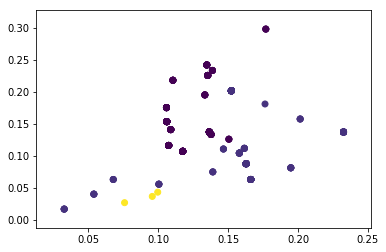

In [12]:
plt.scatter(embeddings[:,0], embeddings[:,1], c=test_instr_labels)
if model_type == "vae":
    plt.scatter(means[:,0], means[:,1], c=test_instr_labels)
    plt.scatter(variances[:,0], variances[:,1], c=test_instr_labels)

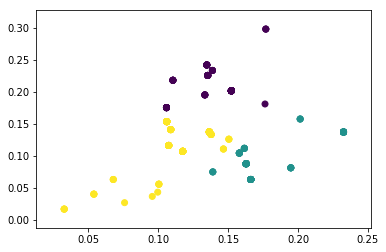

In [13]:
plt.scatter(embeddings[:,0], embeddings[:,1], c=embed_clusters)
if model_type == "vae":
    plt.scatter(means[:,0], means[:,1], c=embed_clusters)
    plt.scatter(variances[:,0], variances[:,1], c=embed_clusters)

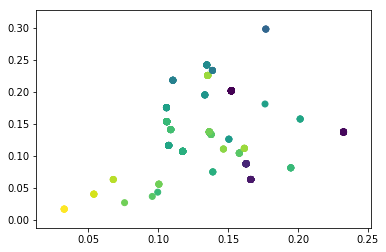

In [14]:
plt.scatter(embeddings[:,0], embeddings[:,1], c=test_pitch_labels)
if model_type == "vae":
    plt.scatter(means[:,0], means[:,1], c=test_pitch_labels)
    plt.scatter(variances[:,0], variances[:,1], c=test_pitch_labels)

In [15]:
n_clusters = n_instruments
hierarchical = sklearn.cluster.AgglomerativeClustering(n_clusters=None, distance_threshold=1.4)
embed_clusters = hierarchical.fit_predict(embeddings)
score = sklearn.metrics.adjusted_rand_score(test_instr_indices, embed_clusters)  
print(score)

0.0


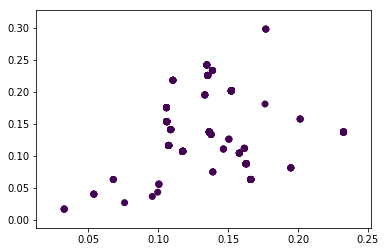

In [16]:
plt.scatter(embeddings[:,0], embeddings[:,1], c=embed_clusters)
if model_type == "vae":
    plt.scatter(means[:,0], means[:,1], c=test_instr_labels)
    plt.scatter(variances[:,0], variances[:,1], c=test_instr_labels)